### Requirements

This notebook was run using the Jupyter Docker container preset `quay.io/jupyter/pytorch-notebook:python-3.11`.

Please launch with sudo access to be able to use `apt-get`: `docker run --user root -e GRANT_SUDO=yes <...>`

In [77]:
%config IPCompleter.greedy=True

### TEI Preprocessing
We preprocess a PDF of our source material: *Deep Learning* by Goodfellow, et al. (available [here](https://www.deeplearningbook.org/))

Text extraction is done following Alpizar-Chacon & Sosnovsky, 2020. The code for the TEI pipeline is available on Github ([link](https://github.com/intextbooks/ITCore?tab=readme-ov-file)), and requires the deployment and coordination of multiple software components. Specifically, it requires MySQL, Apache Jena, and a partial local copy of DBPedia. Their data pipeline is also available for reference as a web service at https://intextbooks.science.uu.nl/.

We optionally enabled "identify index terms in text" and "link entities to DBPedia" using the category "https://<span/>dbpedia.org/page/Category:Technology."

### XML Data-Munging
We process the XML output of the TEI pipeline as described in Yao 2023.

#### install stuff

In [78]:
!sudo apt-get -qq update
!sudo apt-get -qq --yes install graphviz

In [ ]:
!conda install -q -y pygraphviz
!pip install xmltodict==0.13.0
!pip install networkx==3.2.1
!pip install jsonlines==4.0.0

In [80]:
import itertools
import os
import pickle
import random
import re
import xmltodict

#### ingest xml

In [81]:
_file = open("DLB_TEI/teiModel.xml")

book = xmltodict.parse(
    _file.read(),
    xml_attribs=True,
)

_file.close()

#### get section headings from table of contents

In [82]:
# crawl the XML tree in search of items with text
# return a list of table of contents item headings
def grab_toc_headings(node):
    items = []
    if type(node) is dict:
        keys = node.keys()
        if "#text" in keys:
            tup = (
                node["#text"],
                node["ref"].get("@target", "NO_TARGET"),
                
            )
            items.append(tup)
        if "item" in keys:
            items += grab_toc_headings(node["item"])
        if "list" in keys:
            items += grab_toc_headings(node["list"])
    if type(node) is list:
        for elem in node:
            items += grab_toc_headings(elem)
    return items

# remove section numbers from heading text like "1.2.3 foo bar section"
def strip_toc_headings(lst):
    return [
        # (heading.split(" ", maxsplit=1)[-1].strip(), ref) for heading, ref in lst
        (re.split(r"\d+", heading)[-1].strip(), ref) for heading, ref in lst
    ]

table_of_contents = book["TEI"]["front"]["div"]
toc_headings = grab_toc_headings(table_of_contents)
clean_toc_headings = strip_toc_headings(toc_headings)

In [108]:
# sanity check of toc data
toc_headings[:4]

[('1 introduction', 'seg_1'),
 ('i applied math and machine learning basics', 'NO_TARGET'),
 ('ii deep networks: modern practices', 'NO_TARGET'),
 ('1.1 who should read this book?', 'seg_3')]

In [109]:
# sanity check of clean toc data
clean_toc_headings[:4]

[('introduction', 'seg_1'),
 ('i applied math and machine learning basics', 'NO_TARGET'),
 ('ii deep networks: modern practices', 'NO_TARGET'),
 ('who should read this book?', 'seg_3')]

#### get index entries
For some books, TEI fails to distinguish the *bibliography* section and the *index* section. It just combines papers, citations, and index terms. We filter these out. It also tends to interpret page ranges in bib citations ("pages 177-228") as if they were indexes back into the book text.

We use a simple heuristic of checking the string length of items that TEI identifies as index entries and set a cutoff between the point where the actual index items end and the bibliographic citations begin.

This is not completely effective, because TEI also has trouble with two-column layouts that are common in book indexes. For about 15% of the items, it produces combinations like "Point estimator, 119 Reinforcement learning." This results in several relative long, garbled index items.

For the Deep Learning Book, we just set a heuristic of 65 chars. In this book, it separates index items from bib citations. In other cases, it might also filter out extra-long garbled index items.

In [85]:
# remove bibliography citations that TEI mixed into the index for some reason
# we just use excessive length as the heuristic
# every index item for the Deep Learning Book is under 70 characters
def remove_overlong_items(lst):
    return [
        elem for elem in lst
        if type(elem) is dict and len(elem.get("#text", "")) < 70
    ]

# filter out stuff like "Object detection, 444 Probability distribution"
def filter_combined_items(lst):
    return [
        elem for elem in lst
        if len(re.split(r",\s+\d+", elem.get("#text", ""))) == 1
    ]

# process index into tuples that look like ("foo", set(seg_id...))
def grab_index_tuples(lst):
    tuples = []
    for elem in lst:
        elem_name = elem["#text"]
        if "ref" in elem.keys():
            ref = elem["ref"]
            if type(ref) is dict:
                target = ref.get("@target", "NO_TARGET")
                tup = (elem_name, set([target]))
                tuples.append(tup)
            if type(ref) is list:
                targets = set(r.get("@target", "NO_TARGET") for r in ref)
                tup = (elem_name, targets)
                tuples.append(tup)
    return tuples

# util function
all_pairs = lambda lst: itertools.permutations(lst, 2)

# for index items that have a "FOO, see BAR"
# we make a dict of all pairs "foo=bar" and "bar=foo"
# all lowercase, for canonical lookups
def grab_index_aliases(lst):
    alias_dict = {}
    sameas_uri = "owl:sameAs"
    for elem in lst:
        elem_name = elem["#text"]
        ref = elem.get("seg", {}).get("ref", {})
        
        if type(ref) is dict and ref.get("@property", "") == sameas_uri:
            equivalents = map(str.lower, [
                elem_name,
                normalize_prop_uri(ref["@resource"]),
            ])
            alias_dict.update(all_pairs(equivalents))

        if type(ref) is list:
            equivalents = map(str.lower, [
                elem_name,
                *(
                    normalize_prop_uri(r["@resource"])
                    for r in ref
                    if r.get("@property", "") == sameas_uri
                ),
            ])
            alias_dict.update(all_pairs(equivalents))
    
    return alias_dict

# add the "FOO, see BAR" terms to the index dict
# with the same segments as BAR
def enrich_with_aliases(index_dict, alias_dict):
    index_dict_copy = dict(index_dict)
    keys = list(index_dict_copy.keys())
    keys_lower = list(map(str.lower, keys))
    for key, alias in alias_dict.items():
        if key not in keys_lower:
            matching_term = next((k for k in keys if k.lower() == alias), None)
            if matching_term != None:
                index_dict_copy[key] = index_dict[matching_term]
    return index_dict_copy

# property URIs look something like https://intextbooks.science.uu.nl/model/XXX/property_name
model_domain = book["TEI"]["teiHeader"]["fileDesc"]["publicationStmt"]["pubPlace"]
model_id = book["TEI"]["teiHeader"]["fileDesc"]["titleStmt"]["title"].rsplit(" ", maxsplit=1)[-1]
model_property_uri_prefix = f"{model_domain}model/{model_id}/"
normalize_prop_uri = lambda s: s.removeprefix(model_property_uri_prefix).replace("_", " ").lower()

index_items = book["TEI"]["back"]["div"]["list"]["item"]
index_items_filtered = filter_combined_items(remove_overlong_items(index_items))
index_tuples = grab_index_tuples(index_items_filtered)
alias_dict = grab_index_aliases(index_items_filtered)
index_dict = dict(index_tuples)
index_dict_all = enrich_with_aliases(index_dict, alias_dict)

In [112]:
# sanity check of index dict items
[*itertools.islice(index_dict_all.items(), 10)]

[('Absolute value rectification', {'seg_103'}),
 ('Accuracy', {'seg_207'}),
 ('Activation function', {'seg_99'}),
 ('Active constraint', {'seg_71'}),
 ('AdaGrad', {'seg_151'}),
 ('Adam', {'seg_153', 'seg_211'}),
 ('Adaptive linear element', {'seg_5'}),
 ('Adversarial example', {'seg_137'}),
 ('Adversarial training', {'seg_137', 'seg_141', 'seg_267'}),
 ('Affine', {'seg_77'})]

In [113]:
# find longest index texts to set a cutoff threshold
sorted([len(elem["#text"]) for elem in index_items if type(elem) is dict], reverse=True)[:50]

[210,
 207,
 166,
 165,
 163,
 156,
 148,
 133,
 122,
 107,
 105,
 79,
 61,
 59,
 50,
 49,
 49,
 49,
 47,
 46,
 45,
 43,
 42,
 42,
 42,
 40,
 40,
 39,
 38,
 38,
 37,
 37,
 36,
 36,
 36,
 35,
 33,
 33,
 32,
 31,
 31,
 31,
 30,
 30,
 29,
 29,
 29,
 29,
 29,
 29]

#### Assembling Book Data into Triples

In [88]:
from collections import defaultdict

# reverse lookup from segment id to set of index items
segment2indexitem = defaultdict(set)
for item, segs in index_dict_all.items():
    for seg in segs:
        segment2indexitem[seg].add(item.lower())

# map toc headings to segment id for forward lookup
lower_toc_headings = defaultdict(set)
for heading, seg in clean_toc_headings:
    if seg != "NO_TARGET":
        lower_toc_headings[f"the section about {heading.lower()}"].add(seg)

# forward lookup of segment id from each toc item, then lookup of index items from segment ids
triples = []
for heading, segs in lower_toc_headings.items():
    for seg in segs:
        for index_item in segment2indexitem[seg]:
            triple_contains = (heading.lower(), "contains", index_item.lower())
            triple_appears = (index_item.lower(), "appears in", heading.lower())
            triples.append(triple_contains)
            triples.append(triple_appears)


In [90]:
# sanity checking of triples in KG skeleton
_tmp = '\t\n'.join(
    map(
        lambda tup: ', '.join(tup),
        triples[-10:],
    )
)
print(f"Num triples from book: {len(triples)}\nSample triples:\n{_tmp}")

Num triples from book: 1084
Sample triples:
the section about directed generative nets, contains, generative moment matching networks	
generative moment matching networks, appears in, the section about directed generative nets	
the section about directed generative nets, contains, approximate bayesian computation	
approximate bayesian computation, appears in, the section about directed generative nets	
the section about directed generative nets, contains, ais	
ais, appears in, the section about directed generative nets	
the section about directed generative nets, contains, annealed importance sampling	
annealed importance sampling, appears in, the section about directed generative nets	
the section about directed generative nets, contains, gans	
gans, appears in, the section about directed generative nets


### Wikidata enrichment
Use the Neo4J query API to look for matching entities in Wikidata.

#### Wikidata Query Notes
See:
- https://www.wikidata.org/wiki/Wikidata:SPARQL_tutorial
- https://www.mediawiki.org/wiki/Wikidata_Query_Service/User_Manual
- https://www.wikidata.org/wiki/Wikidata:SPARQL_query_service/queries

Notes:
- RDF resource description framework (w3c standard)
- OWL web ontology language
- subject-predicate-object
- <http://www.wikidata.org/entity/Q30> x 3 or wd:Q30  wdt:P36  wd:Q61 .
- wdt for truthy, props have a ranking of current truthiness
- subj and prop are uri's, value not necessarily

In [91]:
from operator import itemgetter
from urllib.request import Request, urlopen
from urllib.parse import urlencode
import json
import time

wikidata_url = "https://query.wikidata.org/sparql"

# limit for sparql queries
limit_results = 30

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/sparql-results+json",
}

# try to map string terms to wikidata entity URIs
# this is a very loose mapping: we don't control for ambiguous terms,
# or distinct things with the same name
# we just search for the term by its wikidata label,
# attempting to match on lowercase, CAPS, and Title Case
def get_sparql_for_entity_term_lookup(term):
    return {
        "query": f"""
            PREFIX wikibase: <http://wikiba.se/ontology#>
            
            SELECT DISTINCT ?item ?itemLabel ?itemDescription
            
            WHERE {{
              VALUES ( ?termAsis ?termTitle ?termLower ?termCaps )
              
              {{ (
                  "{term}"@en
                  "{term.title()}"@en
                  "{term.lower()}"@en
                  "{term.upper()}"@en
              ) }}
              
              {{ ?item rdfs:label ?termAsis }}
              UNION
              {{ ?item rdfs:label ?termTitle }}
              UNION
              {{ ?item rdfs:label ?termLower }}
              UNION
              {{ ?item rdfs:label ?termCaps }} .
              
              SERVICE wikibase:label {{
                bd:serviceParam wikibase:language "en" .
              }}
            }}
        """
    }

# same as `get_sparql_for_entity_term_lookup`, but counts results instead
def get_sparql_for_entity_term_count_lookup(term):
    return {
        "query": f"""
            PREFIX wikibase: <http://wikiba.se/ontology#>
            
            SELECT DISTINCT (COUNT(?item) AS ?count)
            
            WHERE {{
              VALUES ( ?termAsis ?termTitle ?termLower ?termCaps )
              
              {{ (
                  "{term}"@en
                  "{term.title()}"@en
                  "{term.lower()}"@en
                  "{term.upper()}"@en
              ) }}
              
              {{ ?item rdfs:label ?termAsis }}
              UNION
              {{ ?item rdfs:label ?termTitle }}
              UNION
              {{ ?item rdfs:label ?termLower }}
              UNION
              {{ ?item rdfs:label ?termCaps }} .
              
              SERVICE wikibase:label {{
                bd:serviceParam wikibase:language "en" .
              }}
            }}
        """
    }

# For entity E, query all (E Relation Object),
# filtering for English-language object and relation labels.
# E has to be a full URI, e.g. "http://www.wikidata.org/entity/Q3757".
def get_sparql_for_subject_position_triples(entity):
    term, uri, label = itemgetter("term", "uri", "label")(entity)
    return {
        "query": f"""
            PREFIX wikibase: <http://wikiba.se/ontology#>

            SELECT ?subjectLabel ?predicate ?predicateEntityLabel ?object ?objectLabel {{

                # suggested here: https://www.wikidata.org/wiki/Wikidata:SPARQL_query_service/queries#Adding_labels_for_properties
                hint:Query hint:optimizer "None" .

                VALUES ( ?subjectLabel ) {{ (
                    "{label}"
                ) }}

                <{uri}> ?predicate ?object .

                # directClaim associates predicates (WDT's) with entities (WD's), and only entities have labels
                ?predicateEntity wikibase:directClaim ?predicate .

                ?predicateEntity rdfs:label ?predicateEntityLabel .

                ?object rdfs:label ?objectLabel .

                FILTER (
                    lang(?predicateEntityLabel) = "en" &&
                    lang(?objectLabel) = "en" 
                )

            }}
            LIMIT {limit_results}
        """
    }

# For entity E, query all (Subject Relation Entity),
# filtering for English-language subject and relation labels,
# and EXCLUDING relation P921 "main subject,"
# which returns results that are too numerous and too specific.
# E has to be a full URI, e.g. "http://www.wikidata.org/entity/Q3757".
def get_sparql_for_object_position_triples(entity):
    term, uri, label = itemgetter("term", "uri", "label")(entity)
    return {
        "query": f"""
            PREFIX wikibase: <http://wikiba.se/ontology#>

            SELECT ?subject ?subjectLabel ?predicate ?predicateEntityLabel ?objectLabel {{

                # suggested here: https://www.wikidata.org/wiki/Wikidata:SPARQL_query_service/queries#Adding_labels_for_properties
                hint:Query hint:optimizer "None" .

                VALUES ( ?objectLabel ) {{ (
                    "{label}"
                ) }}

                ?subject ?predicate <{uri}> .

                # directClaim associates predicates (WDT's) with entities (WD's), and only entities have labels
                ?predicateEntity wikibase:directClaim ?predicate .

                ?predicateEntity rdfs:label ?predicateEntityLabel .

                ?subject rdfs:label ?subjectLabel .

                FILTER (
                    lang(?predicateEntityLabel) = "en" &&
                    lang(?subjectLabel) = "en"
                )

                MINUS {{
                    # not "X main_subject Y" there are too many overly specific ones  
                    ?subject wdt:P921 <{uri}> .
                }}

            }}
            LIMIT {limit_results}
        """
    }

# wrapper to send SPARQL queries
def query_wikidata(sparql):
    body = urlencode(sparql).encode()

    def make_request():
        req = Request(url=wikidata_url, headers=headers, data=body)
        return urlopen(req)

    # respect being throttled by wikidata
    while (response := make_request()) and response.getcode() == 429:
        print(f"Got 429 Too Many Requests when querying for [{query}], backing off!")
        delay = response.getheader("Retry-After") or response.getheader("retry-after")
        delay_secs = 1.05 * float(delay)
        print(f"Wikidata tells us to try again after [{delay}] seconds, sleeping...")
        time.sleep(delay_secs)

    response_json = json.load(response)
    results = response_json["results"]["bindings"]

    return results


# returns triples of (Entity <verb> <object>)
def get_subject_position_triples_for_entity(entity):
    sparql = get_sparql_for_subject_position_triples(entity)
    results = query_wikidata(sparql)
    return [
        (
            r["subjectLabel"]["value"].lower(),
            r["predicateEntityLabel"]["value"].lower(),
            r["objectLabel"]["value"].lower(),
        ) for r in results
    ]

# returns triples of (<subject> <verb> Entity)
def get_object_position_triples_for_entity(entity):
    sparql = get_sparql_for_object_position_triples(entity)
    results = query_wikidata(sparql)
    return [
        (
            r["subjectLabel"]["value"].lower(),
            r["predicateEntityLabel"]["value"].lower(),
            r["objectLabel"]["value"].lower(),
        ) for r in results
    ]

# maps plain words to sets of Wikidata entity identifiers
def get_entities_from_term(term):
    sparql = get_sparql_for_entity_term_lookup(term)
    results = query_wikidata(sparql)
    return [
        {
            "term": term,
            "uri": result["item"]["value"],
            "label": result["itemLabel"]["value"],
            "description": result.get("itemDescription", {}).get("value", "NO_DESCRIPTION")
        }
        for result in results
    ]

# returns triples in both subjec and object position
def get_all_triples_for_term(term):
    entities = get_entities_from_term(term)
    return [
        *[
            triple
                for e in entities
                for triple in get_subject_position_triples_for_entity(e)
        ],
        *[
            triple
                for e in entities
                for triple in get_object_position_triples_for_entity(e)
        ],
    ]

def count_entities_for_term(term):
    sparql = get_sparql_for_entity_term_count_lookup(term)
    res = query_wikidata(sparql)
    return int(res[0]["count"]["value"])


In [115]:
# sanity check of Wikidata API
get_object_position_triples_for_entity(get_entities_from_term("autoencoder")[0])

[('autocoder', 'different from', 'autoencoder'),
 ('variational auto-encoder', 'subclass of', 'autoencoder'),
 ('conditional variational autoencoder', 'subclass of', 'autoencoder'),
 ('denoising autoencoder', 'subclass of', 'autoencoder')]

In [116]:
# sanity check of Wikidata API
count_entities_for_term("autoencoder")

2

### Putting the Dataset Together
We have the triples of (TOC section heading, "contains", index term). We now enrich this set of triples by looking up index terms in Wikidata. We add triples of (Entity, Relation, index term) and (index term, Relation, Entity) with an upper limit of 50 added per item per position.

In [136]:
terms = set()

for subj, verb, obj in triples:
    terms.add(subj)
    terms.add(obj)

terms = sorted(terms)
print(f"Number of terms to look up in Wikidata: {len(terms)}")

Number of terms to look up in Wikidata: 505


#### Load triples from a previous run, if already available. If not, scrape them from Wikidata (takes time).

In [97]:
import pickle
import os

cap_per_term = 50
dump_file = "wiki_triples.pickle"

def load_triples():
    with open(dump_file, "rb") as f:
        data = pickle.load(f)
    return data

def slowly_scrape_triples_from_wiki(terms):
    for i, term in enumerate(terms):
        capped = False
        if term in ("adam", "independence"): # the worst overloaded words
            continue
        extras = get_all_triples_for_term(term)
        if len(extras) > cap_per_term:
            extras = extras[:cap_per_term]
            capped = True
        print(f"[{i:-3d}/{len(terms)}] Got {len(extras)} triples for term {term}. {'(CAPPED)' if capped else ''}")
        wiki_triples.extend(extras)
    
    with open(dump_file, "wb") as f:
        print(f"Saving data to {dump_file}.")
        pickle.dump(wiki_triples, f)
    
    return wiki_triples

if os.path.isfile(dump_file):
    print("Wiki triples file present, loading from file.")
    wiki_triples = load_triples()
else:
    print("Wiki triples pickle file absent, starting scrape.")
    wiki_triples = slowly_scrape_triples_from_wiki()

print(f"Total Wiki triples: {len(wiki_triples)}")
wiki_triples[:10]

Wiki triples file present, loading from file.
Total Wiki triples: 3666


[('accuracy', 'instance of', 'music track with vocals'),
 ('accuracy', 'performer', 'the cure'),
 ('accuracy', 'genre', 'post-punk'),
 ('accuracy', 'different from', 'accuracy'),
 ('accuracy', 'producer', 'chris parry'),
 ('accuracy', 'recording or performance of', 'accuracy'),
 ('accuracy', 'distribution format', 'music streaming'),
 ('accuracy', 'recorded at studio or venue', 'morgan studios'),
 ('accuracy', 'contributor to the creative work or subject', 'robert smith'),
 ('accuracy',
  'contributor to the creative work or subject',
  'michael dempsey')]

#### Combine the local and scraped triples.

In [98]:
all_triples = triples + wiki_triples
print(f"Total triples from book and WikiBase: {len(all_triples)}")

all_entities = set()
all_edges = set()
for subj, verb, obj in all_triples:
    all_entities.add(subj)
    all_entities.add(obj)
    all_edges.add(verb)

print(f"Total entities from book and WikiBase: {len(all_entities)}")
print(f"Number of unique edge types: {len(all_edges)}")

Total triples from book and WikiBase: 4750
Total entities from book and WikiBase: 2837
Number of unique edge types: 223


#### Build the `networkx` MultiDiGraph.

In [99]:
import networkx as nx

mdg = nx.MultiDiGraph()

for i, entity in enumerate(all_entities):
    mdg.add_node(entity, name=entity, index=i)

for subj, verb, obj in all_triples:
    mdg.add_edge(subj, obj, name=verb)

num_weak_comp = nx.number_weakly_connected_components(mdg)
print(f"KG has {num_weak_comp} weakly connected components.")
weak_comp_sizes = [len(comp) for comp in nx.weakly_connected_components(mdg)]
print(f"KG weakly connected components have sizes: {weak_comp_sizes}")

KG has 21 weakly connected components.
KG weakly connected components have sizes: [2734, 2, 44, 7, 2, 2, 6, 4, 2, 2, 7, 2, 2, 4, 2, 4, 2, 3, 2, 2, 2]


In [100]:
from collections import deque

# Given a graph, pick a random node and BFS outward until you accumulate max_nodes.
# If you can't get that many nodes (because you're in a dead end of the graph), return None.
def get_random_neighborhood(mdg, max_nodes):
    num_nodes = mdg.number_of_nodes()
    rand_ind = random.randint(0, num_nodes - 1)
    rand_node = [node for node, data in mdg.nodes(data=True) if data["index"] == rand_ind][0]

    seen_nodes = set()
    seen_nodes.add(rand_node)
    found_triples = list()
    queue = deque()
    queue.append(rand_node)

    while len(queue) > 0:
        curr_node = queue.popleft()
        for neighbor in mdg.neighbors(curr_node):
            if neighbor not in seen_nodes:
                queue.append(neighbor)
                seen_nodes.add(neighbor)
    
                edge_types = [v["name"] for v in mdg.get_edge_data(curr_node, neighbor).values()]
                for edge_type in edge_types:
                    found_triple = (rand_node, edge_type, neighbor)
                    found_triples.append(found_triple)
                
                if len(seen_nodes) == max_nodes:
                    return {"answer": rand_node, "neighborhood": found_triples}
    return {"answer": rand_node, "neighborhood": found_triples} if len(seen_nodes) == max_nodes else None

In [101]:
# reshape a graph neighborhood expressed as a list of triples into a PQ-style query object
def form_neighborhood_into_pq_entry(data, ind):
    answer, triples = data["answer"], data["neighborhood"]

    pq_obj = {
        "answers": [],
        "outSeq": "", # generate answers
        "qId": 0,
        "inGraph": {
            "g_node_names": {},
            "g_edge_types": {},
            "g_adj": {},
        }
    }

    pq_obj["answers"].append(answer)
    pq_obj["qId"] = ind

    g = pq_obj["inGraph"]

    for subj, verb, obj in triples:
        g["g_node_names"][subj] = subj
        g["g_node_names"][obj] = obj
        g["g_edge_types"][verb] = verb
        
        adj = g["g_adj"]
        
        if subj not in adj:
            adj[subj] = {}
        if obj not in adj[subj]:
            adj[subj][obj] = []
        adj[subj][obj].append(verb)

    return pq_obj

#### Create sample subgraphs from KG.

In [102]:
neighborhood_target_num_nodes = 6
target_num_neighborhoods = 100
pq_queries = []

hits = 0
while hits < target_num_neighborhoods:
    rn = get_random_neighborhood(mdg, 5)
    if rn is not None:
        hits += 1
        pq = form_neighborhood_into_pq_entry(rn, hits)
        pq_queries.append(pq)

#### Save sampled subgraphs to file.

In [25]:
import jsonlines

with open("test.ndjson", "w") as f:
    with jsonlines.Writer(f) as writer:
        for pq in pq_queries:
            writer.write(pq)

#### Visualize the completed KG.

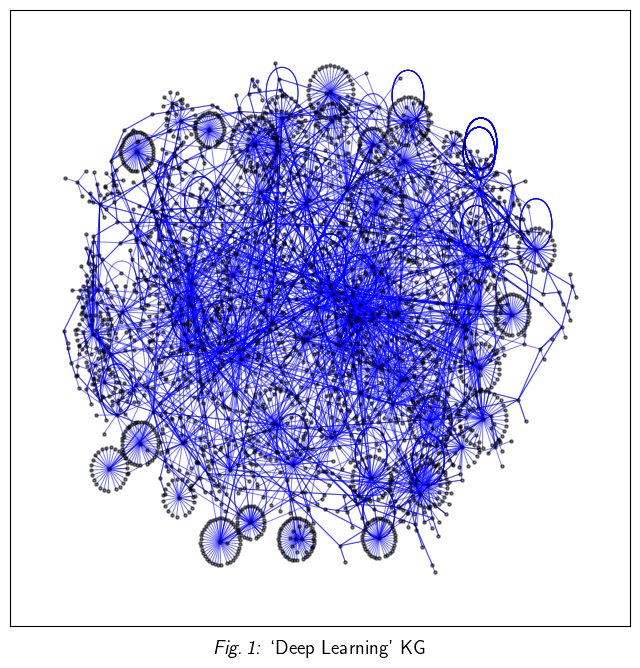

In [66]:
import matplotlib.pyplot as plt

mdg_giant = mdg.subgraph(next(nx.weakly_connected_components(mdg)))

_pos = nx.drawing.nx_agraph.graphviz_layout(mdg_giant, prog="sfdp", args="""
    -Gbeautify
    -GK=8.0
    -Gquadtree=fast
    -Grepulsiveforce=1.5
    -Gsmoothing=none
""")

plt.figure(figsize=(8, 8))

nx.draw_networkx_edges(
    mdg_giant,
    edge_color='b',
    pos=_pos,
    width=0.75,
    alpha=0.5,
    arrows=False,
)

nx.draw_networkx_nodes(
    mdg_giant,
    pos=_pos,
    node_size=5,
    node_color='k',
    alpha=0.5,
)

plt.title("\\textit{{Fig.\,1:}} `Deep Learning' KG", y=-0.06, usetex=True, fontsize=14)
plt.savefig("fig1.png", format="png", bbox_inches="tight");